### Differential abundance analyses

#### 1. Load required libraries

In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("apeglm")
# install.packages("pheatmap")
library(pheatmap, warn.conflicts = F, quietly = T)
library(ggplot2, warn.conflicts = F, quietly = T)
library(DESeq2, warn.conflicts = F, quietly = T)
library(edgeR, warn.conflicts = F, quietly = T)
library(apeglm, warn.conflicts = F, quietly = T)

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”

Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
  

#### 2. Load data

In [6]:
# metadata <- read.table("map.txt", header=T, sep="\t")
# row.names(metadata) <- metadata$sample_id
# genecounts <- read.table("../02-STAR/homd_mapped_strict/featurecounts/read_counts.txt", header=T, sep="\t", row.names = 1)
# # fix sample names gene count file
# colnames(genecounts) <- gsub(x = names(genecounts), pattern = "X", replacement = "UF")  
head(metadata)
head(genecounts)

,sample_id,tooth_type,individual_id,caries_status,original_sample_id,novaseq_id,volume_used_ul,protein_mg_ml,ads_nmol_min_mg_of_protein,concentration_ng_ul
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
UF10PD,UF10PD,PD,B10,CA,B10-PD,10PD,120,0.153,8.9,7.74
UF115PD,UF115PD,PD,B115,CA,B115-PD,115PD,120,0.083,20.181,26.51
UF12PD,UF12PD,PD,B12,CA,B12-PD,12PD,80,0.222,16.45,5.29
UF15PD,UF15PD,PD,B115,CA,B115-PD,15PD,120,0.083,20.181,14.23
UF20PD,UF20PD,PD,B20,CA,B20-PD,20PD,80,0.71,12.521,13.84
UF21PD,UF21PD,PD,B21,CA,B21-PD,21PD,100,0.275,26.929,13.10


,UF10PD,UF115PD,UF12PD,UF15PD,UF20PD,UF21PD,UF25PD,UF25PER,UF26PD,UF36PER,⋯,UF53PD,UF53PER,UF54PD,UF54PER,UF58PD,UF59PD,UF67PDR,UF68PD,UF69PD,UF76PDR
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
SEQF1003_00001,20,0,60,0,7,132,28,2,1,2,⋯,22,31,86,1,13,14,37,8,1,7
SEQF1003_00002,4,0,34,0,6,16,6,3,1,1,⋯,20,8,16,0,24,1,5,7,0,0
SEQF1003_00004,19,0,189,0,16,122,24,4,7,1,⋯,20,36,118,1,62,21,34,13,11,6
SEQF1003_00008,0,0,0,0,0,0,0,0,0,0,⋯,24,15,0,0,14,0,0,0,0,0
SEQF1003_00009,3,0,0,0,0,0,3,0,0,0,⋯,19,6,0,0,2,0,0,0,0,0
SEQF1003_00010,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


#### 3. Format for DESeq2 analysis

In [9]:
# only compare PD to PE
metadata <- metadata[metadata$tooth_type != "PF",]
# dim(metadata)
# only keep columns found in metadata
genecounts <- genecounts[, colnames(genecounts) %in% row.names(metadata)]
# dim(genecounts)
# reorder by metadata rownames
metadata <- metadata[order(colnames(genecounts)),]
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = genecounts, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PE"))

[1] 37 10

[1] 3907188      37

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 1123610 37 
metadata(1): version
assays(1): counts
rownames(1123610): SEQF1003_00001 SEQF1003_00002 ... SEQF3050_00046
  SEQF3050_00510
rowData names(0):
colnames(37): UF10PD UF115PD ... UF69PD UF76PDR
colData names(10): sample_id tooth_type ... ads_nmol_min_mg_of_protein
  concentration_ng_ul

#### 4. Run DESeq2

In [10]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm # this takes about an hour to complete
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function
norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 351328 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



    user   system  elapsed 
5428.217  332.789 4402.342 

In [11]:
# save.image()
res <- results(se_star, alpha=0.01)
# order by p value
res <- res[order(res$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(res$padj < 0.01, na.rm=TRUE))
summary(res)

[1] "number of genes with adjusted p value lower than 0.01:  62675"


out of 1111589 with nonzero total read count
adjusted p-value < 0.01
LFC > 0 (up)       : 11317, 1%
LFC < 0 (down)     : 51358, 4.6%
outliers [1]       : 0, 0%
low counts [2]     : 442800, 40%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [12]:
resultsNames(se_star)

[1] "Intercept"           "tooth_type_PE_vs_PD"

In [13]:
# filter out low count genes
resLFC <- lfcShrink(se_star, coef="tooth_type_PE_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(resLFC$padj < 0.01, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results_pdvpe.txt", quote=F, sep="\t")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of genes with adjusted p value lower than 0.01:  59693"


out of 1111589 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 53839, 4.8%
LFC < 0 (down)     : 114497, 10%
outliers [1]       : 0, 0%
low counts [2]     : 313564, 28%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



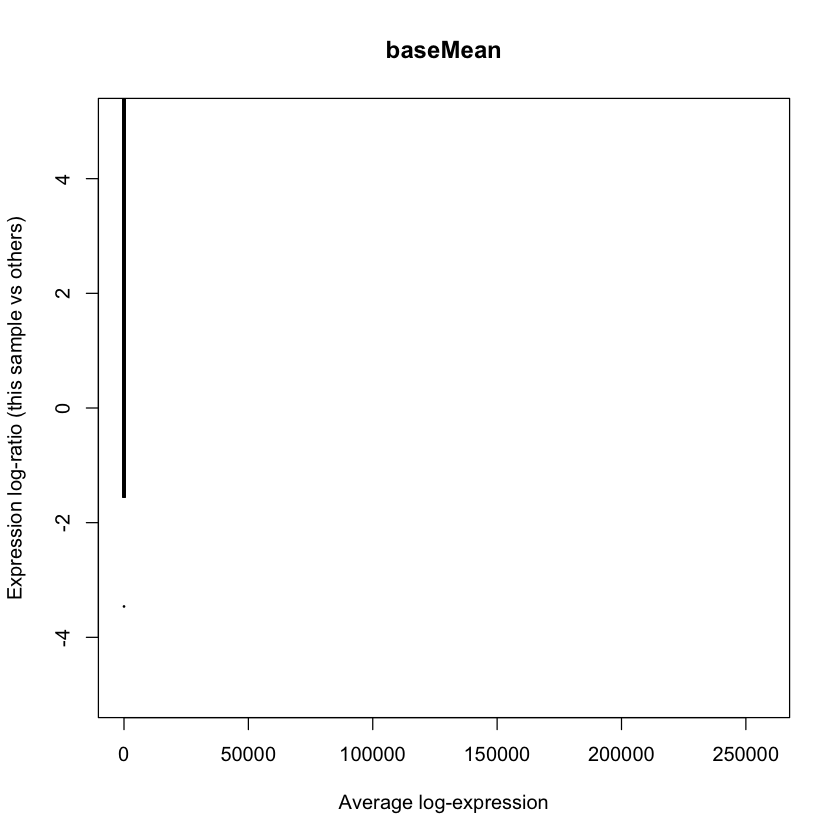

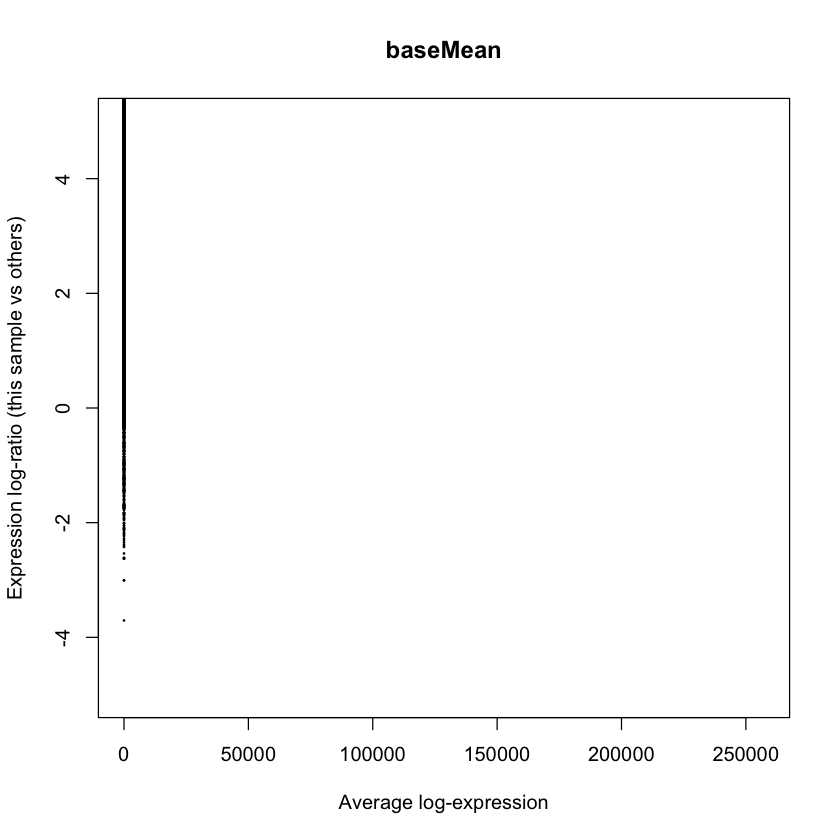

In [14]:
plotMA(res, ylim=c(-5,5))
plotMA(resLFC, ylim=c(-5,5))

In [15]:
# transform for visualizations
vld <- vst(se_star)

In [ ]:
#Get 25 top varying genes
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 25)
 
#make a subset of the log transformed counts for just the top 25 varying genes
top25Counts <- assay(vld)[topVarGenes,]
write.csv(top25Counts, file="top25counts.vld.pdvpe.csv", quote=FALSE)
 
#PLOT PCA
#PCA using top 500 varying genes
pdf("pca_pdvpe.pdf")
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()

pdf 
  2

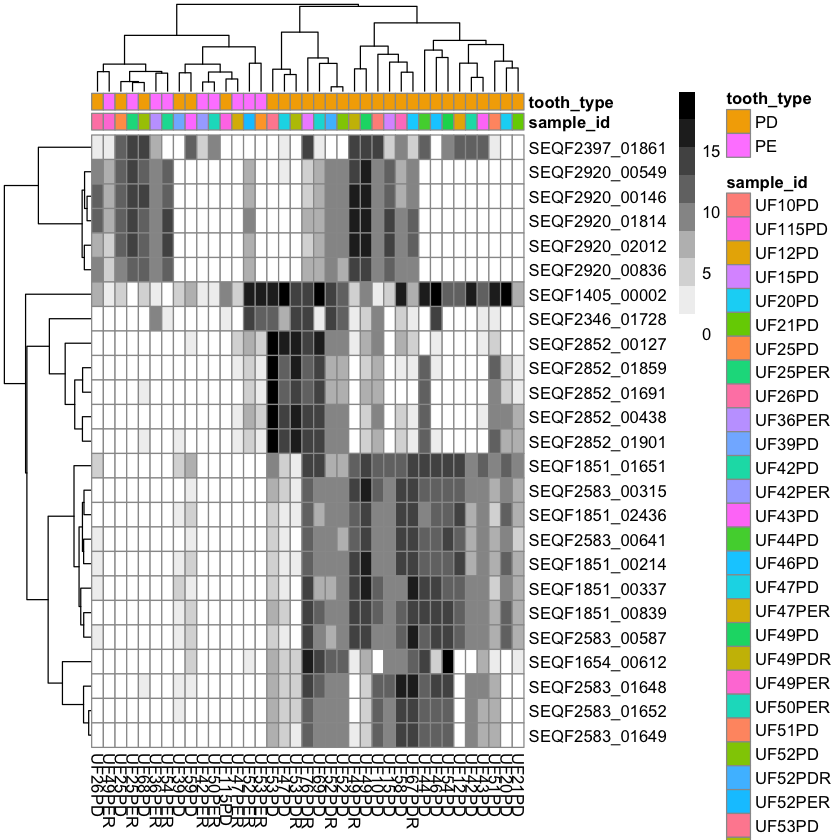

In [13]:
# will have to change sample_id to something more meaningful in final run
df <- as.data.frame(colData(vld)[,c("sample_id","tooth_type")])
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
library(RColorBrewer)
x <- pheatmap(top25Counts, annotation_col = df, color = brewer.pal(9, "Greys"))
save_pheatmap_pdf(x, "heatmap_pdvpe.pdf")